# Proyecto 2 - Deep Learning

## Integrantes

- Integrante1 - Código
- Integrante2 - Código
- Integrante3 - Código

## Modelo 1

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

DATASET_PATH = "/kaggle/input/datasnake-test/CLASIFICADOR SNAKES"

In [2]:
# =====================================
# CONFIGURAR DISPOSITIVO
# =====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [3]:
# =====================================
# TRANSFORMACIONES (3 canales para ResNet)
# =====================================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# =====================================
# CARGA DE DATOS Y PARTICIÓN
# =====================================
dataset = datasets.ImageFolder(DATASET_PATH)
class_names = dataset.classes

targets = np.array(dataset.targets)

train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.1,
    stratify=targets,
    random_state=42
)

train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform_train)
test_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform_test)

train_dataset = Subset(train_dataset, train_idx)
test_dataset = Subset(test_dataset, test_idx)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
# =====================================
# CARGAR RESNET18 PREENTRENADA Y MODIFICAR CABEZA
# =====================================
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Congelar capas convolucionales
for param in resnet18.parameters():
    param.requires_grad = False

num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(class_names))
)

resnet18_model1 = resnet18.to(device)

optimizer = optim.Adam(resnet18_model1.fc.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [6]:
# =====================================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN
# =====================================
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    history = {"train_loss": [], "test_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        acc = evaluate_model(model, test_loader)

        history["train_loss"].append(avg_loss)
        history["test_acc"].append(acc)

        print(f"Época {epoch}/{epochs} - Loss: {avg_loss:.4f} | Test Acc: {acc:.4f}")

    return history

In [7]:
# =====================================
# ENTRENAMIENTO
# =====================================
print("\nEntrenando modelo ResNet18...")
%time history_model1 = train_model(resnet18_model1, train_loader, test_loader, optimizer, criterion, epochs=45)

final_acc_model1 = evaluate_model(resnet18_model1, test_loader)
print(f"\nAccuracy final de ResNet18: {final_acc_model1:.2f}")


Entrenando modelo ResNet18...
Época 1/45 - Loss: 1.1043 | Test Acc: 0.5263
Época 2/45 - Loss: 0.8975 | Test Acc: 0.7895
Época 3/45 - Loss: 0.7741 | Test Acc: 0.7895
Época 4/45 - Loss: 0.6804 | Test Acc: 0.6842
Época 5/45 - Loss: 0.6772 | Test Acc: 0.9474
Época 6/45 - Loss: 0.5663 | Test Acc: 0.6842
Época 7/45 - Loss: 0.5025 | Test Acc: 0.8421
Época 8/45 - Loss: 0.5789 | Test Acc: 0.7895
Época 9/45 - Loss: 0.5886 | Test Acc: 0.8421
Época 10/45 - Loss: 0.4805 | Test Acc: 0.7895
Época 11/45 - Loss: 0.5519 | Test Acc: 0.7368
Época 12/45 - Loss: 0.6124 | Test Acc: 0.8421
Época 13/45 - Loss: 0.5072 | Test Acc: 0.7895
Época 14/45 - Loss: 0.4268 | Test Acc: 0.8421
Época 15/45 - Loss: 0.4762 | Test Acc: 0.8421
Época 16/45 - Loss: 0.4662 | Test Acc: 0.7368
Época 17/45 - Loss: 0.3903 | Test Acc: 0.8421
Época 18/45 - Loss: 0.3885 | Test Acc: 0.8421
Época 19/45 - Loss: 0.4197 | Test Acc: 0.8421
Época 20/45 - Loss: 0.4326 | Test Acc: 0.8947
Época 21/45 - Loss: 0.4887 | Test Acc: 0.8421
Época 22/45 

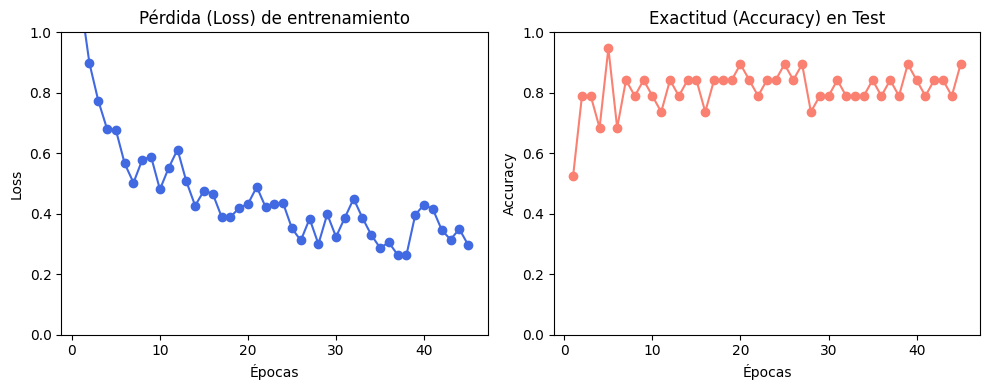

In [8]:
# =====================================
# PLOT DE LOSS Y ACCURACY
# =====================================
epochs = range(1, len(history_model1["train_loss"]) + 1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_model1["train_loss"], 'royalblue', marker='o', linestyle='-')
plt.title("Pérdida (Loss) de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.ylim((0,1))

plt.subplot(1,2,2)
plt.plot(epochs, history_model1["test_acc"], 'salmon', marker='o', linestyle='-')
plt.title("Exactitud (Accuracy) en Test")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.ylim((0,1))


plt.tight_layout()
plt.show()

## Modelo 2

In [9]:
# =====================================
# TRANSFORMACIONES (3 canales para ResNet)
# =====================================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [10]:
# =====================================
# CARGA DE DATOS Y PARTICIÓN
# =====================================
dataset = datasets.ImageFolder(DATASET_PATH)
class_names = dataset.classes
targets = np.array(dataset.targets)

train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.1,
    stratify=targets,
    random_state=42
)

train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform_train)
test_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform_test)

train_dataset = Subset(train_dataset, train_idx)
test_dataset = Subset(test_dataset, test_idx)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [14]:
# =====================================
# CARGAR RESNET18 PREENTRENADA (fine-tuning completo)
# =====================================
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Descongelar TODAS las capas (fine-tuning completo)
for param in resnet18.parameters():
    param.requires_grad = True

# Reemplazar la capa final (fc)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, len(class_names))
)

resnet18_model2 = resnet18.to(device)

# Importante: tasa de aprendizaje más baja al hacer fine-tuning
optimizer = optim.Adam(resnet18_model2.parameters(), lr=1e-4, weight_decay=1e-3)  # antes 1e-3
criterion = nn.CrossEntropyLoss()

In [15]:
# =====================================
# ENTRENAMIENTO
# =====================================
print("\nEntrenando modelo ResNet18 (fine-tuning completo)...")
%time history_model2 = train_model(resnet18_model2, train_loader, test_loader, optimizer, criterion, epochs=45)

final_acc_model2 = evaluate_model(resnet18_model2, test_loader)
print(f"\nAccuracy final de ResNet18 (fine-tuning): {final_acc_model2:.2f}")


Entrenando modelo ResNet18 (fine-tuning completo)...
Época 1/45 - Loss: 1.0300 | Test Acc: 0.8421
Época 2/45 - Loss: 0.6809 | Test Acc: 0.8421
Época 3/45 - Loss: 0.4805 | Test Acc: 0.9474
Época 4/45 - Loss: 0.3463 | Test Acc: 0.9474
Época 5/45 - Loss: 0.2950 | Test Acc: 0.8947
Época 6/45 - Loss: 0.1553 | Test Acc: 0.8421
Época 7/45 - Loss: 0.1580 | Test Acc: 0.8947
Época 8/45 - Loss: 0.0930 | Test Acc: 0.8421
Época 9/45 - Loss: 0.0819 | Test Acc: 0.7368
Época 10/45 - Loss: 0.0721 | Test Acc: 0.8947
Época 11/45 - Loss: 0.0878 | Test Acc: 0.8947
Época 12/45 - Loss: 0.0692 | Test Acc: 0.8947
Época 13/45 - Loss: 0.0790 | Test Acc: 0.9474
Época 14/45 - Loss: 0.0425 | Test Acc: 0.8947
Época 15/45 - Loss: 0.0744 | Test Acc: 0.8947
Época 16/45 - Loss: 0.0629 | Test Acc: 1.0000
Época 17/45 - Loss: 0.0315 | Test Acc: 1.0000
Época 18/45 - Loss: 0.0585 | Test Acc: 0.8947
Época 19/45 - Loss: 0.0444 | Test Acc: 0.8947
Época 20/45 - Loss: 0.0482 | Test Acc: 0.8421
Época 21/45 - Loss: 0.0636 | Test A

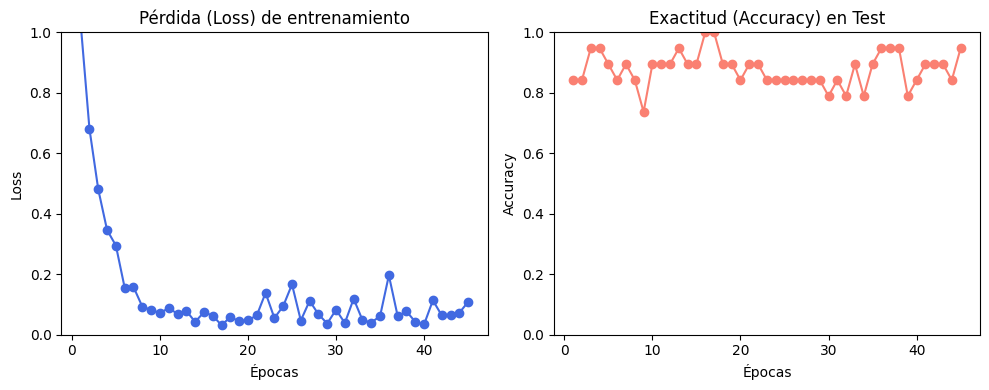

In [16]:
# =====================================
# PLOT DE LOSS Y ACCURACY
# =====================================
epochs = range(1, len(history_model2["train_loss"]) + 1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_model2["train_loss"], 'royalblue', marker='o', linestyle='-')
plt.title("Pérdida (Loss) de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.ylim((0,1))

plt.subplot(1,2,2)
plt.plot(epochs, history_model2["test_acc"], 'salmon', marker='o', linestyle='-')
plt.title("Exactitud (Accuracy) en Test")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.ylim((0,1))

plt.tight_layout()
plt.show()

# Puntos a realizar


1. Correr ambas partes por varias épocas y ver cómo varía el accuracy con las épocas a medida que se estabiliza la pérdida. Una vez que sus modelos se estabilicen, deberán obtener los últimos 10 valores del accuracy que quedan oscilando para los modelos propuestos en ambas partes. Posterior a ello, con los datos obtenidos calculen un intervalo de confianza al 95% usando una distribución t de Student para estimar entre qué valores está el valor promedio del accuracy para ambos conjuntos de datos.  Con base en eso, justifiquen si el accuracy mejora ajustando los filtros de las capas residuales o si es igual que usando los valores por defecto (primera parte).

In [19]:
import scipy.stats as stats

CONFIDENCE_LVL = 0.95

In [23]:
data_model1 = history_model1.get('test_acc')[-10:]
print(data_model1)

ci_model1 = stats.t.interval(
    CONFIDENCE_LVL,
    df=len(data_model1)-1,
    loc=np.mean(data_model1),
    scale=np.std(data_model1, ddof=1) / np.sqrt(len(data_model1))   
)

ci_model1 = list(map(lambda x: float(f"{x:.2f}"), ci_model1))

print("MODELO 1")
print(f"Intervalo de confianza (nivel confianza={CONFIDENCE_LVL}): {ci_model1}")

[0.7894736842105263, 0.8421052631578947, 0.7894736842105263, 0.8947368421052632, 0.8421052631578947, 0.7894736842105263, 0.8421052631578947, 0.8421052631578947, 0.7894736842105263, 0.8947368421052632]
MODELO 1
Intervalo de confianza (nivel confianza=0.95): [0.8, 0.86]


In [24]:
data_model2 = history_model2.get('test_acc')[-10:]
print(data_model2)

ci_model2 = stats.t.interval(
    CONFIDENCE_LVL,
    df=len(data_model2)-1,
    loc=np.mean(data_model2),
    scale=np.std(data_model2, ddof=1) / np.sqrt(len(data_model2))
)

ci_model2 = list(map(lambda x: float(f"{x:.2f}"), ci_model2))

print("MODELO 2")
print(f"Intervalo de confianza (nivel confianza={CONFIDENCE_LVL}): {ci_model2}")

[0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.7894736842105263, 0.8421052631578947, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8421052631578947, 0.9473684210526315]
MODELO 2
Intervalo de confianza (nivel confianza=0.95): [0.86, 0.93]


**Respuesta.** Con un nivel de significancia del $5\%$ ...

2. Para ambas partes deberán meter una capa adicional entre la de entrada, de 128 neuronas y la de salida (de tamaño `len(class_names)`). Esta capa deberá recibir las 128 activaciones de las neuronas y pasarlas por 64 neuronas. Posterior a este cambio, vuelvan a sacar el IC con los últimos 10 accuracy (tal como en el punto anterior) y discutan si el accuracy mejora o empeora con este cambio para la primera y segunda parte.


## Modelo 1 - parte 2

In [25]:
# =====================================
# CARGAR RESNET18 PREENTRENADA Y MODIFICAR CABEZA
# =====================================
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Congelar capas convolucionales
for param in resnet18.parameters():
    param.requires_grad = False

num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(64, len(class_names))
)

resnet18_model1_pt2 = resnet18.to(device)

optimizer_model1_pt2 = optim.Adam(resnet18_model1_pt2.fc.parameters(), lr=0.001, weight_decay=1e-3)
criterion_model1_pt2 = nn.CrossEntropyLoss()

In [26]:
# =====================================
# ENTRENAMIENTO
# =====================================
print("\nEntrenando modelo ResNet18 (fine-tuning completo)...")
%time history_model1_pt2 = train_model(resnet18_model1_pt2, train_loader, test_loader, optimizer_model1_pt2, criterion_model1_pt2, epochs=45)

final_acc_model2 = evaluate_model(resnet18_model1_pt2, test_loader)
print(f"\nAccuracy final de ResNet18 (fine-tuning): {final_acc_model2:.2f}")


Entrenando modelo ResNet18 (fine-tuning completo)...
Época 1/45 - Loss: 1.0811 | Test Acc: 0.3684
Época 2/45 - Loss: 1.0522 | Test Acc: 0.8421
Época 3/45 - Loss: 0.9523 | Test Acc: 0.9474
Época 4/45 - Loss: 0.9242 | Test Acc: 0.7368
Época 5/45 - Loss: 0.7632 | Test Acc: 0.8421
Época 6/45 - Loss: 0.7283 | Test Acc: 1.0000
Época 7/45 - Loss: 0.7146 | Test Acc: 0.7368
Época 8/45 - Loss: 0.6187 | Test Acc: 0.8947
Época 9/45 - Loss: 0.6650 | Test Acc: 1.0000
Época 10/45 - Loss: 0.6544 | Test Acc: 0.8421
Época 11/45 - Loss: 0.5279 | Test Acc: 0.8421
Época 12/45 - Loss: 0.5468 | Test Acc: 0.8421
Época 13/45 - Loss: 0.4491 | Test Acc: 0.9474
Época 14/45 - Loss: 0.4531 | Test Acc: 0.8947
Época 15/45 - Loss: 0.4853 | Test Acc: 0.9474
Época 16/45 - Loss: 0.4215 | Test Acc: 0.8947
Época 17/45 - Loss: 0.5630 | Test Acc: 0.8421
Época 18/45 - Loss: 0.4410 | Test Acc: 0.8421
Época 19/45 - Loss: 0.4274 | Test Acc: 0.8947
Época 20/45 - Loss: 0.4482 | Test Acc: 0.8421
Época 21/45 - Loss: 0.4413 | Test A

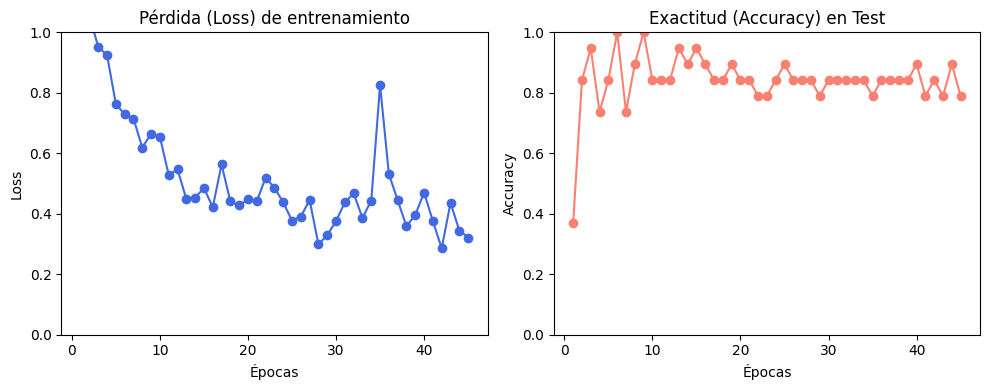

In [27]:
# =====================================
# PLOT DE LOSS Y ACCURACY
# =====================================
epochs = range(1, len(history_model1_pt2["train_loss"]) + 1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_model1_pt2["train_loss"], 'royalblue', marker='o', linestyle='-')
plt.title("Pérdida (Loss) de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.ylim((0,1))

plt.subplot(1,2,2)
plt.plot(epochs, history_model1_pt2["test_acc"], 'salmon', marker='o', linestyle='-')
plt.title("Exactitud (Accuracy) en Test")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.ylim((0,1))

plt.tight_layout()
plt.show()

## Modelo 2 - parte 2

In [34]:
# =====================================
# CARGAR RESNET18 PREENTRENADA (fine-tuning completo)
# =====================================
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Descongelar TODAS las capas (fine-tuning completo)
for param in resnet18.parameters():
    param.requires_grad = True

# Reemplazar la capa final (fc)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(64, len(class_names))
)

resnet18_model2_pt2 = resnet18.to(device)

# Importante: tasa de aprendizaje más baja al hacer fine-tuning
optimizer_model2_pt2 = optim.Adam(resnet18_model2_pt2.parameters(), lr=1e-4, weight_decay=1e-3)  # antes 1e-3
criterion_model2_pt2 = nn.CrossEntropyLoss()

In [35]:
# =====================================
# ENTRENAMIENTO
# =====================================
print("\nEntrenando modelo ResNet18 (fine-tuning completo)...")
%time history_model2_pt2 = train_model(resnet18_model2_pt2, train_loader, test_loader, optimizer_model2_pt2, criterion_model2_pt2, epochs=45)

final_acc_model2 = evaluate_model(resnet18_model2_pt2, test_loader)
print(f"\nAccuracy final de ResNet18 (fine-tuning): {final_acc_model2:.2f}")


Entrenando modelo ResNet18 (fine-tuning completo)...
Época 1/45 - Loss: 1.0845 | Test Acc: 0.6842
Época 2/45 - Loss: 0.9497 | Test Acc: 0.7895
Época 3/45 - Loss: 0.8294 | Test Acc: 0.8947
Época 4/45 - Loss: 0.7284 | Test Acc: 0.9474
Época 5/45 - Loss: 0.6158 | Test Acc: 0.8947
Época 6/45 - Loss: 0.4885 | Test Acc: 0.9474
Época 7/45 - Loss: 0.3816 | Test Acc: 0.8947
Época 8/45 - Loss: 0.3194 | Test Acc: 0.8947
Época 9/45 - Loss: 0.2353 | Test Acc: 1.0000
Época 10/45 - Loss: 0.1849 | Test Acc: 0.8421
Época 11/45 - Loss: 0.1491 | Test Acc: 0.9474
Época 12/45 - Loss: 0.1354 | Test Acc: 0.9474
Época 13/45 - Loss: 0.1126 | Test Acc: 1.0000
Época 14/45 - Loss: 0.1532 | Test Acc: 0.8947
Época 15/45 - Loss: 0.1562 | Test Acc: 0.7895
Época 16/45 - Loss: 0.0735 | Test Acc: 0.8421
Época 17/45 - Loss: 0.0769 | Test Acc: 0.8421
Época 18/45 - Loss: 0.0576 | Test Acc: 0.8947
Época 19/45 - Loss: 0.0858 | Test Acc: 0.9474
Época 20/45 - Loss: 0.1009 | Test Acc: 0.8421
Época 21/45 - Loss: 0.1320 | Test A

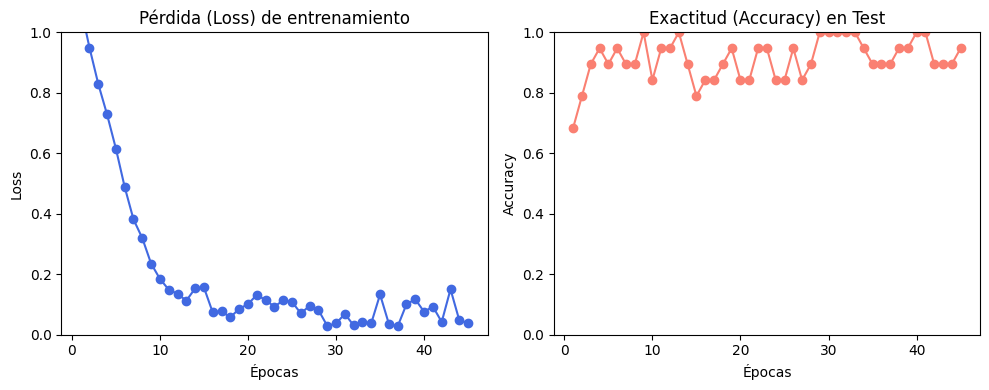

In [36]:
# =====================================
# PLOT DE LOSS Y ACCURACY
# =====================================
epochs = range(1, len(history_model2_pt2["train_loss"]) + 1)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_model2_pt2["train_loss"], 'royalblue', marker='o', linestyle='-')
plt.title("Pérdida (Loss) de entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.ylim((0,1))

plt.subplot(1,2,2)
plt.plot(epochs, history_model2_pt2["test_acc"], 'salmon', marker='o', linestyle='-')
plt.title("Exactitud (Accuracy) en Test")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.ylim((0,1))

plt.tight_layout()
plt.show()

## Cálculo de los intervalos de confianza

Para el modelo 1 con la nueva capa en la red fully connected obtenemos el siguiente intervalo de confianza. 

In [40]:
data_model1 = history_model1_pt2.get('test_acc')[-10:]
print(data_model1)

ci_model1_pt2 = stats.t.interval(
    CONFIDENCE_LVL,
    df=len(data_model1)-1,
    loc=np.mean(data_model1),
    scale=np.std(data_model1, ddof=1) / np.sqrt(len(data_model1))   
)

ci_model1_pt2 = list(map(lambda x: float(f"{x:.2f}"), ci_model1_pt2))


print("MODELO 1")
print(f"Intervalo de confianza (nivel confianza={CONFIDENCE_LVL}): {ci_model1_pt2}")

[0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8947368421052632, 0.7894736842105263, 0.8421052631578947, 0.7894736842105263, 0.8947368421052632, 0.7894736842105263]
MODELO 1
Intervalo de confianza (nivel confianza=0.95): [0.81, 0.86]


Para el modelo 2 con la nueva capa en la red fully connected obtenemos el siguiente intervalo de confianza. 

In [41]:
data_model2 = history_model2_pt2.get('test_acc')[-10:]
print(data_model2)

ci_model2_pt2 = stats.t.interval(
    CONFIDENCE_LVL,
    df=len(data_model2)-1,
    loc=np.mean(data_model2),
    scale=np.std(data_model2, ddof=1) / np.sqrt(len(data_model2))
)

ci_model2_pt2 = list(map(lambda x: float(f"{x:.2f}"), ci_model2_pt2))

print("MODELO 2")
print(f"Intervalo de confianza (nivel confianza={CONFIDENCE_LVL}): {ci_model2_pt2}")

[0.8947368421052632, 0.8947368421052632, 0.9473684210526315, 0.9473684210526315, 1.0, 1.0, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.9473684210526315]
MODELO 2
Intervalo de confianza (nivel confianza=0.95): [0.9, 0.96]


In [44]:
print("Intervalos de confianza:")
print('-'*40)
print(f"Modelo 1 parte 1: {ci_model1}")
print(f"Modelo 1 parte 2: {ci_model1_pt2}")
print('-'*40)
print(f"Modelo 2 parte 1: {ci_model2}")
print(f"Modelo 2 parte 2: {ci_model2_pt2}")

Intervalos de confianza:
----------------------------------------
Modelo 1 parte 1: [0.8, 0.86]
Modelo 1 parte 2: [0.81, 0.86]
----------------------------------------
Modelo 2 parte 1: [0.86, 0.93]
Modelo 2 parte 2: [0.9, 0.96]
